<h1 align="center"> Lip Sync Prediction <h1>
    
<p style="text-align:center"><img src="https://www.reallusion.com/iclone/includes/images/lipsync-animation/lipsync-animation-cc-base-expression-data-4.jpg"/></p>

## Download and Import Libraries

In [1]:
!pip install gdown --quiet

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import imageio
import matplotlib.pyplot as plt
# Change - New Libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix
import nltk

In [2]:
# Change - Set Tensorflow Seed
tf.random.set_seed(123)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import gdown

In [104]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

## Load and Preprocess Data

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     Issue with Precision due to data mismatch
#     return tf.cast((frames - mean), tf.float32) / std
    return (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # Change - Changed Path Delimeter from \\ -> /
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
# test_path = '.\\data\\s1\\bbal6n.mpg'
test_path = "./data/s1/bbal6n.mpg"

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

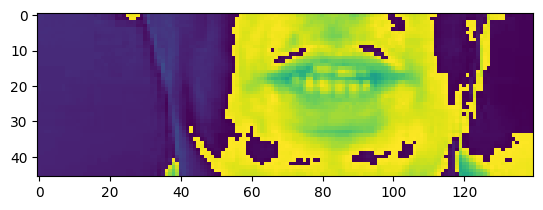

In [15]:
plt.imshow(frames[40])

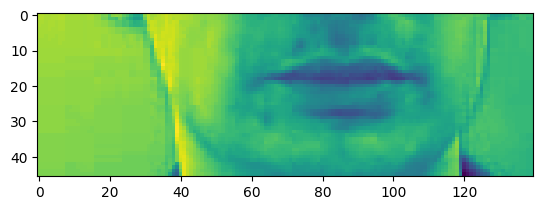

In [16]:
# After Solving Precision issue
plt.imshow(frames[1])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [18]:
def mappable_function(path:str) ->List[str]:
    with tf.device("/cpu:0"):
        result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
        return result

In [19]:
from matplotlib import pyplot as plt

In [59]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Change - Changed name from "data" to "data_shuffled" so that we can use it later if needed, also added seed
data_shuffled = data.shuffle(500, reshuffle_each_iteration=False, seed=123)
data = data_shuffled.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# Change - Setup the Train and test appropriately considering the dastset size of 500
train = data.take(450)
test = data.skip(450)

In [65]:
len([x.decode('utf-8') for x in list(data_shuffled.as_numpy_iterator())][:100])

100

In [22]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)

2

In [24]:
test = data.as_numpy_iterator()

In [105]:
# val = test.next(); val[0]

In [89]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

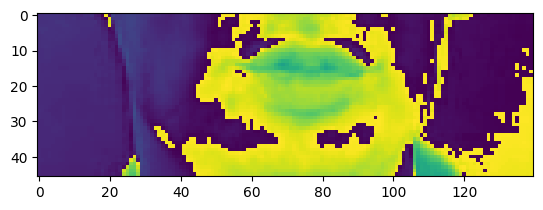

In [90]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [91]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with o two please'>

In [23]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import legacy

In [24]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

## Model Building

In [25]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [27]:
5*17*75

6375

In [106]:
# yhat = model.predict(val[0])

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
model.input_shape

In [29]:
model.output_shape

(None, 75, 41)

In [107]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [108]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [120]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
#         self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [121]:
model.compile(optimizer=legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

## Model Training

In [122]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [123]:
schedule_callback = LearningRateScheduler(scheduler)

In [124]:
example_callback = ProduceExample(test)

In [125]:
# Change - Added Early Stopping Callback to prevent overfiiting
earl_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback, earl_stopping_callback])

Epoch 1/100
 46/450 [==>...........................] - ETA: 5:29 - loss: 4.5487

## Evaluation

In [34]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=bd2eacdf-f2c9-4211-8e6f-12d431ea25f9
To: /kaggle/working/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 92.0MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [35]:
model.load_weights('models/checkpoint')

In [37]:
# Change - Converted test to numpy iterator
test = test.as_numpy_iterator()

In [36]:
test

<SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [46]:
# test_data = test.as_numpy_iterator()

In [40]:
sample = test.next()

In [41]:
sample[0].shape

(2, 75, 46, 140, 1)

In [42]:
yhat = model.predict(sample[0])

1/1 [==============================] - 6s 6s/step


In [43]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at k seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue in b six now'>]

In [44]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [45]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at k seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue in b six now'>]

In [49]:
sample = load_data(tf.convert_to_tensor('./data/s1/lgil7a.mpg'))

In [50]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in l seven again'>]

In [51]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 321ms/step


In [52]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [88]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word).numpy() for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white with v seven soon'>]

In [ ]:
# confusion metrics, tts, accuracy, f1 score ----> improvements, create UI

### Major Changes - Evaluation

### Get Predictions

In [47]:
def decode_to_text(inp_arr):
    decoded_arr = []
    
    for ele in inp_arr:
#         tf string is eager tensor
        tf_string = tf.strings.reduce_join([num_to_char(word) for word in ele])
#     Convert eager tensor to numpy first., then you get bytes not a string,then you have to decode the bytes to convert it to a python string
        decoded_arr.append(str(tf_string.numpy().decode('utf-8')))
        
    if len(decoded_arr) == 1:
        return decoded_arr[0]
    return decoded_arr

In [48]:
decode_to_text([[19, 5, 20, 39, 23, 8, 9, 20, 5, 39, 23, 9, 20, 8, 39, 22, 39, 19, 5, 22, 5, 14, 39, 19, 15, 15, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
               ])

'set white with v seven soon'

In [49]:
def get_predictions(data):
    predicted_text_arr = []
    
    pred = model.predict(data)
    for data_slice in pred:
#         np.newaxis adds a new axis to the data slice such that it is comptible with the model imput dimensions
        decoded = tf.keras.backend.ctc_decode(data_slice[np.newaxis,...], input_length=[75], greedy=True)[0][0].numpy()
        text_output = decode_to_text(decoded)
        predicted_text_arr.append(text_output)
    
    return predicted_text_arr

In [50]:
# ground_truths is y_test
# predicted labels is y_pred
ground_truths = []
predicted_labels = []

In [53]:
from tqdm import tqdm
progress_bar = tqdm(total=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
for data in test:
    ground_truth = decode_to_text(data[1])
    predicted_label = get_predictions(data[0])
    
    ground_truths.append(ground_truth)
    predicted_labels.append(predicted_label)
    progress_bar.update()

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1/50 [00:22<18:32, 22.71s/it]

1/1 [==============================] - 0s 176ms/step


  4%|▍         | 2/50 [00:23<07:47,  9.73s/it]

1/1 [==============================] - 0s 180ms/step


  6%|▌         | 3/50 [00:23<04:22,  5.58s/it]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 4/50 [00:24<02:46,  3.62s/it]

1/1 [==============================] - 0s 177ms/step


 10%|█         | 5/50 [00:25<01:54,  2.54s/it]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 6/50 [00:26<01:26,  1.97s/it]

1/1 [==============================] - 0s 170ms/step


 14%|█▍        | 7/50 [00:26<01:08,  1.60s/it]

1/1 [==============================] - 0s 181ms/step


 16%|█▌        | 8/50 [00:27<00:59,  1.41s/it]

1/1 [==============================] - 0s 182ms/step


 18%|█▊        | 9/50 [00:28<00:49,  1.22s/it]

1/1 [==============================] - 0s 213ms/step


 20%|██        | 10/50 [00:29<00:47,  1.19s/it]

1/1 [==============================] - 0s 175ms/step


 22%|██▏       | 11/50 [00:30<00:41,  1.08s/it]

1/1 [==============================] - 0s 177ms/step


 24%|██▍       | 12/50 [00:31<00:38,  1.00s/it]

1/1 [==============================] - 0s 172ms/step


 26%|██▌       | 13/50 [00:32<00:35,  1.04it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██▊       | 14/50 [00:33<00:33,  1.06it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███       | 15/50 [00:34<00:34,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 16/50 [00:35<00:31,  1.07it/s]

1/1 [==============================] - 0s 174ms/step


 34%|███▍      | 17/50 [00:36<00:29,  1.10it/s]

1/1 [==============================] - 0s 166ms/step


 36%|███▌      | 18/50 [00:36<00:28,  1.11it/s]

1/1 [==============================] - 0s 173ms/step


[mpeg1video @ 0x7977e4089100] ac-tex damaged at 22 17
[mpeg1video @ 0x7977e4089100] Warning MVs not available
 38%|███▊      | 19/50 [00:37<00:27,  1.14it/s]

1/1 [==============================] - 0s 174ms/step


 40%|████      | 20/50 [00:38<00:26,  1.15it/s]

1/1 [==============================] - 0s 173ms/step


 42%|████▏     | 21/50 [00:39<00:25,  1.16it/s]

1/1 [==============================] - 0s 177ms/step


 44%|████▍     | 22/50 [00:40<00:23,  1.17it/s]

1/1 [==============================] - 0s 175ms/step


 46%|████▌     | 23/50 [00:41<00:23,  1.17it/s]

1/1 [==============================] - 0s 175ms/step


 48%|████▊     | 24/50 [00:41<00:22,  1.17it/s]

1/1 [==============================] - 0s 174ms/step


 50%|█████     | 25/50 [00:42<00:21,  1.18it/s]

1/1 [==============================] - 0s 172ms/step


 52%|█████▏    | 26/50 [00:43<00:20,  1.16it/s]

1/1 [==============================] - 0s 177ms/step


 54%|█████▍    | 27/50 [00:44<00:19,  1.16it/s]

1/1 [==============================] - 0s 211ms/step


 56%|█████▌    | 28/50 [00:45<00:21,  1.05it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████▊    | 29/50 [00:46<00:19,  1.06it/s]

1/1 [==============================] - 0s 172ms/step


 60%|██████    | 30/50 [00:47<00:18,  1.10it/s]

1/1 [==============================] - 0s 172ms/step


 62%|██████▏   | 31/50 [00:48<00:17,  1.09it/s]

1/1 [==============================] - 0s 169ms/step


 64%|██████▍   | 32/50 [00:49<00:15,  1.13it/s]

1/1 [==============================] - 0s 174ms/step


 66%|██████▌   | 33/50 [00:50<00:14,  1.15it/s]

1/1 [==============================] - 0s 171ms/step


 68%|██████▊   | 34/50 [00:50<00:13,  1.16it/s]

1/1 [==============================] - 0s 172ms/step


 70%|███████   | 35/50 [00:51<00:12,  1.17it/s]

1/1 [==============================] - 0s 176ms/step


 72%|███████▏  | 36/50 [00:52<00:11,  1.18it/s]

1/1 [==============================] - 0s 179ms/step


 74%|███████▍  | 37/50 [00:53<00:11,  1.17it/s]

1/1 [==============================] - 0s 170ms/step


 76%|███████▌  | 38/50 [00:54<00:10,  1.18it/s]

1/1 [==============================] - 0s 172ms/step


 78%|███████▊  | 39/50 [00:55<00:09,  1.18it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████  | 40/50 [00:55<00:08,  1.19it/s]

1/1 [==============================] - 0s 171ms/step


 82%|████████▏ | 41/50 [00:56<00:07,  1.19it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▍ | 42/50 [00:57<00:07,  1.12it/s]

1/1 [==============================] - 0s 172ms/step


 86%|████████▌ | 43/50 [00:58<00:05,  1.21it/s]

1/1 [==============================] - 0s 173ms/step


 88%|████████▊ | 44/50 [00:59<00:05,  1.18it/s]

1/1 [==============================] - 0s 172ms/step


 90%|█████████ | 45/50 [01:00<00:04,  1.19it/s]

1/1 [==============================] - 0s 173ms/step


 92%|█████████▏| 46/50 [01:01<00:03,  1.19it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████▍| 47/50 [01:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 169ms/step


 96%|█████████▌| 48/50 [01:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 49/50 [01:03<00:00,  1.29it/s]

In [73]:
pred.shape

(2, 75, 41)

In [66]:
test_file_names = [x.decode('utf-8') for x in list(data_shuffled.as_numpy_iterator())]

In [68]:
# test_file_names

In [72]:
ground_truth_arr = list(np.array(ground_truths).ravel())
predicted_label_arr = list(np.array(predicted_labels).ravel())

## Core Evaluation Metrics

1. **Precision**: Precision is the fraction of true positive predictions (TP) among the total positive predictions made by the model. It measures how well the model correctly identifies positive instances. The formula for precision is:

    $$ Precision = \frac{TP}{TP + FP} $$

   where TP is the number of true positives, and FP is the number of false positives.

2. **Recall**: Recall is the fraction of true positive predictions (TP) among the total actual positive instances. It measures how well the model identifies all the positive instances. The formula for recall is:

    $$ Recall = \frac{TP}{TP + FN} $$

   where TP is the number of true positives, and FN is the number of false negatives.

3. **Accuracy**: Accuracy is the fraction of correct predictions (both true positives and true negatives) among the total number of predictions made by the model. The formula for accuracy is:

    $$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

   where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.


4. **F1 Score**: The F1 score is the harmonic mean of precision and recall. It is used when both precision and recall are equally important. The formula for the F1 score is:

    $$ F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall} $$

5. **Confusion Matrix**: A confusion matrix is a table that is used to describe the performance of a classification model. It shows the true positive, true negative, false positive, and false negative predictions for each class label. The confusion matrix is represented as:

    ```
    [ [ TP, FP ],
      [ FN, TN ] ]
    ```

   where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

## Character Level Evaluation

In [73]:
def calculate_character_accuracy(true_labels, predicted_labels):
    """
    Calculates the character-level accuracy score between true labels and predicted labels.
    """
    total_chars = 0
    correct_chars = 0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
        total_chars += len(true_label)
        for true_char, predicted_char in zip(true_label, predicted_label):
            if true_char == predicted_char:
                correct_chars += 1

    return correct_chars / total_chars

def calculate_character_precision(true_labels, predicted_labels):
    """
    Calculates the character-level precision score between true labels and predicted labels.
    """
    true_positive = 0
    false_positive = 0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
        for true_char, predicted_char in zip(true_label, predicted_label):
            if true_char == predicted_char:
                true_positive += 1
            else:
                false_positive += 1

    return true_positive / (true_positive + false_positive)

def calculate_character_recall(true_labels, predicted_labels):
    """
    Calculates the character-level recall score between true labels and predicted labels.
    """
    true_positive = 0
    false_negative = 0

    for true_label, predicted_label in zip(true_labels, predicted_labels):
        for true_char, predicted_char in zip(true_label, predicted_label):
            if true_char == predicted_char:
                true_positive += 1
            else:
                false_negative += 1

    return true_positive / (true_positive + false_negative)

def calculate_character_f1_score(true_labels, predicted_labels):
    """
    Calculates the character-level F1 score between true labels and predicted labels.
    """
    precision = calculate_character_precision(true_labels, predicted_labels)
    recall = calculate_character_recall(true_labels, predicted_labels)

    return 2 * (precision * recall) / (precision + recall)


In [76]:
def calculate_character_metrics(true_labels, predicted_labels):
    """
    Calculates character-level accuracy, precision, recall, and F1 score.
    Generates a confusion matrix using Seaborn.
    """
    # Calculate metrics
    accuracy = calculate_character_accuracy(true_labels, predicted_labels)
    precision = calculate_character_precision(true_labels, predicted_labels)
    recall = calculate_character_recall(true_labels, predicted_labels)
    f1_score = calculate_character_f1_score(true_labels, predicted_labels)

    # Return metrics and confusion matrix
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    return metrics


In [78]:
char_metrics = calculate_character_metrics(ground_truth_arr, predicted_label_arr)
print(char_metrics)

{'Accuracy': 0.983739837398374, 'Precision': 0.9869494290375204, 'Recall': 0.9869494290375204, 'F1 Score': 0.9869494290375204}


In [80]:
print("Character Level Accuracy:", f"{char_metrics['Accuracy']*100:.2f}%")
print("Character Level Precision:", f"{char_metrics['Precision']*100:.2f}%")
print("Character Level Recall:", f"{char_metrics['Recall']*100:.2f}%")
print("Character Level F1 Score:", f"{char_metrics['F1 Score']*100:.2f}%")


Character Level Accuracy: 98.37%
Character Level Precision: 98.69%
Character Level Recall: 98.69%
Character Level F1 Score: 98.69%


In [85]:
def generate_confusion_matrix(predicted_sentences, expected_sentences, vocabulary):
    """
    Generates a confusion matrix based on character-level predictions.
    """
    # Initialize confusion matrix
    num_classes = len(vocabulary)
    confusion_mat = np.zeros((num_classes, num_classes))

    # Iterate over each pair of predicted and expected sentences
    for predicted_sent, expected_sent in zip(predicted_sentences, expected_sentences):
        # Convert sentences to character-level lists
        predicted_chars = list(predicted_sent)
        expected_chars = list(expected_sent)

        # Iterate over each pair of predicted and expected characters
        for predicted_char, expected_char in zip(predicted_chars, expected_chars):
            # Find the indices of predicted and expected characters in the vocabulary
            predicted_idx = vocabulary.index(predicted_char)
            expected_idx = vocabulary.index(expected_char)

            # Increment the corresponding entry in the confusion matrix
            confusion_mat[expected_idx][predicted_idx] += 1

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=vocabulary, yticklabels=vocabulary)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Characters')
    plt.ylabel('Expected Characters')
    plt.show()


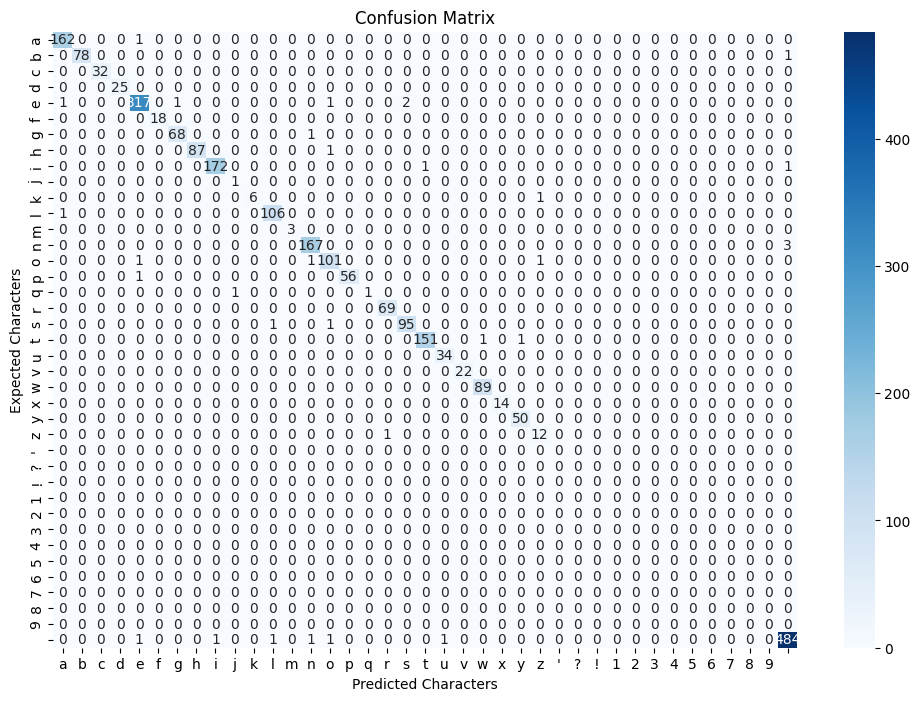

In [86]:
generate_confusion_matrix(predicted_label_arr, ground_truth_arr, vocab)

## Character Error Rate (CER)

Character Error Rate (CER) is similar to WER but operates at the character level. It measures the accuracy of the predicted text by considering the minimum number of character-level substitutions, deletions, and insertions required to align the predicted and true text.

The formula for calculating CER is as follows:

CER = (S + D + I) / C

where:
- S is the number of character substitutions,
- D is the number of character deletions,
- I is the number of character insertions,
- C is the total number of characters in the ground truth labels.

In [101]:
def calculate_cer(predicted, ground_truth):
    """
    Calculate Character Error Rate (CER)
    """
    
    total_chars = 0
    total_errors = 0

    for pred_sent, true_sent in zip(predicted, ground_truth):
        pred_chars = list(pred_sent)
        true_chars = list(true_sent)

        # Calculate the Levenshtein distance
        distance = nltk.edit_distance(pred_chars, true_chars)

        total_chars += len(true_chars)
        total_errors += distance

    cer = float(total_errors) / total_chars

    return cer

In [102]:
cer = calculate_cer(predicted_label_arr, ground_truth_arr)

In [103]:
print(f"Character Error Rate: {cer*100:.2f}%")

Character Error Rate: 0.73%


## Word Level Evaluation

In [87]:
def calculate_word_accuracy(predicted_sentences, expected_sentences):
    """
    Calculates word-level accuracy.
    """
    total_words = 0
    correct_words = 0

    for predicted_sent, expected_sent in zip(predicted_sentences, expected_sentences):
        total_words += 1
        if predicted_sent == expected_sent:
            correct_words += 1

    return correct_words / total_words


def calculate_word_precision(predicted_sentences, expected_sentences):
    """
    Calculates word-level precision.
    """
    true_positive = 0
    false_positive = 0

    for predicted_sent, expected_sent in zip(predicted_sentences, expected_sentences):
        if predicted_sent == expected_sent:
            true_positive += 1
        else:
            false_positive += 1

    return true_positive / (true_positive + false_positive)


def calculate_word_recall(predicted_sentences, expected_sentences):
    """
    Calculates word-level recall.
    """
    true_positive = 0
    false_negative = 0

    for predicted_sent, expected_sent in zip(predicted_sentences, expected_sentences):
        if predicted_sent == expected_sent:
            true_positive += 1
        else:
            false_negative += 1

    return true_positive / (true_positive + false_negative)


def calculate_word_f1_score(predicted_sentences, expected_sentences):
    """
    Calculates word-level F1 score.
    """
    precision = calculate_word_precision(predicted_sentences, expected_sentences)
    recall = calculate_word_recall(predicted_sentences, expected_sentences)

    return 2 * (precision * recall) / (precision + recall)


In [88]:
def calculate_word_metrics(predicted_sentences, expected_sentences):
    """
    Calculates word-level accuracy, precision, recall, and F1 score.
    Generates a confusion matrix based on word-level predictions.
    """
    # Calculate metrics
    accuracy = calculate_word_accuracy(predicted_sentences, expected_sentences)
    precision = calculate_word_precision(predicted_sentences, expected_sentences)
    recall = calculate_word_recall(predicted_sentences, expected_sentences)
    f1_score = calculate_word_f1_score(predicted_sentences, expected_sentences)

    # Return metrics and confusion matrix
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    return metrics


In [89]:
word_metrics = calculate_character_metrics(ground_truth_arr, predicted_label_arr)
print(word_metrics)

{'Accuracy': 0.983739837398374, 'Precision': 0.9869494290375204, 'Recall': 0.9869494290375204, 'F1 Score': 0.9869494290375204}


In [119]:
print("Word Level Accuracy:", f"{word_metrics['Accuracy']*100:.2f}%")
print("Word Level Precision:", f"{word_metrics['Precision']*100:.2f}%")
print("Word Level Recall:", f"{word_metrics['Recall']*100:.2f}%")
print("Word Level F1 Score:", f"{word_metrics['F1 Score']*100:.2f}%")

Word Level Accuracy: 98.37%
Word Level Precision: 98.69%
Word Level Recall: 98.69%
Word Level F1 Score: 98.69%


In [93]:
def generate_word_confusion_matrix(predicted_sentences, expected_sentences):
    """
    Generates a word-level confusion matrix.
    """
    # Get unique words from predicted and expected sentences
    predicted_words = set([word for sent in predicted_sentences for word in sent.split()])
    expected_words = set([word for sent in expected_sentences for word in sent.split()])

    # Get sorted list of unique words
    unique_words = sorted(predicted_words.union(expected_words))

    # Initialize confusion matrix
    num_classes = len(unique_words)
    confusion_mat = np.zeros((num_classes, num_classes))

    # Iterate over each pair of predicted and expected sentences
    for predicted_sent, expected_sent in zip(predicted_sentences, expected_sentences):
        # Convert sentences to word-level lists
        predicted_words = predicted_sent.split()
        expected_words = expected_sent.split()

        # Iterate over each pair of predicted and expected words
        for predicted_word, expected_word in zip(predicted_words, expected_words):
            # Find the indices of predicted and expected words in the unique word list
            predicted_idx = unique_words.index(predicted_word)
            expected_idx = unique_words.index(expected_word)

            # Increment the corresponding entry in the confusion matrix
            confusion_mat[expected_idx][predicted_idx] += 1

    # Plot confusion matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=unique_words, yticklabels=unique_words)
    plt.title('Word-level Confusion Matrix')
    plt.xlabel('Predicted Words')
    plt.ylabel('Expected Words')
    plt.show()


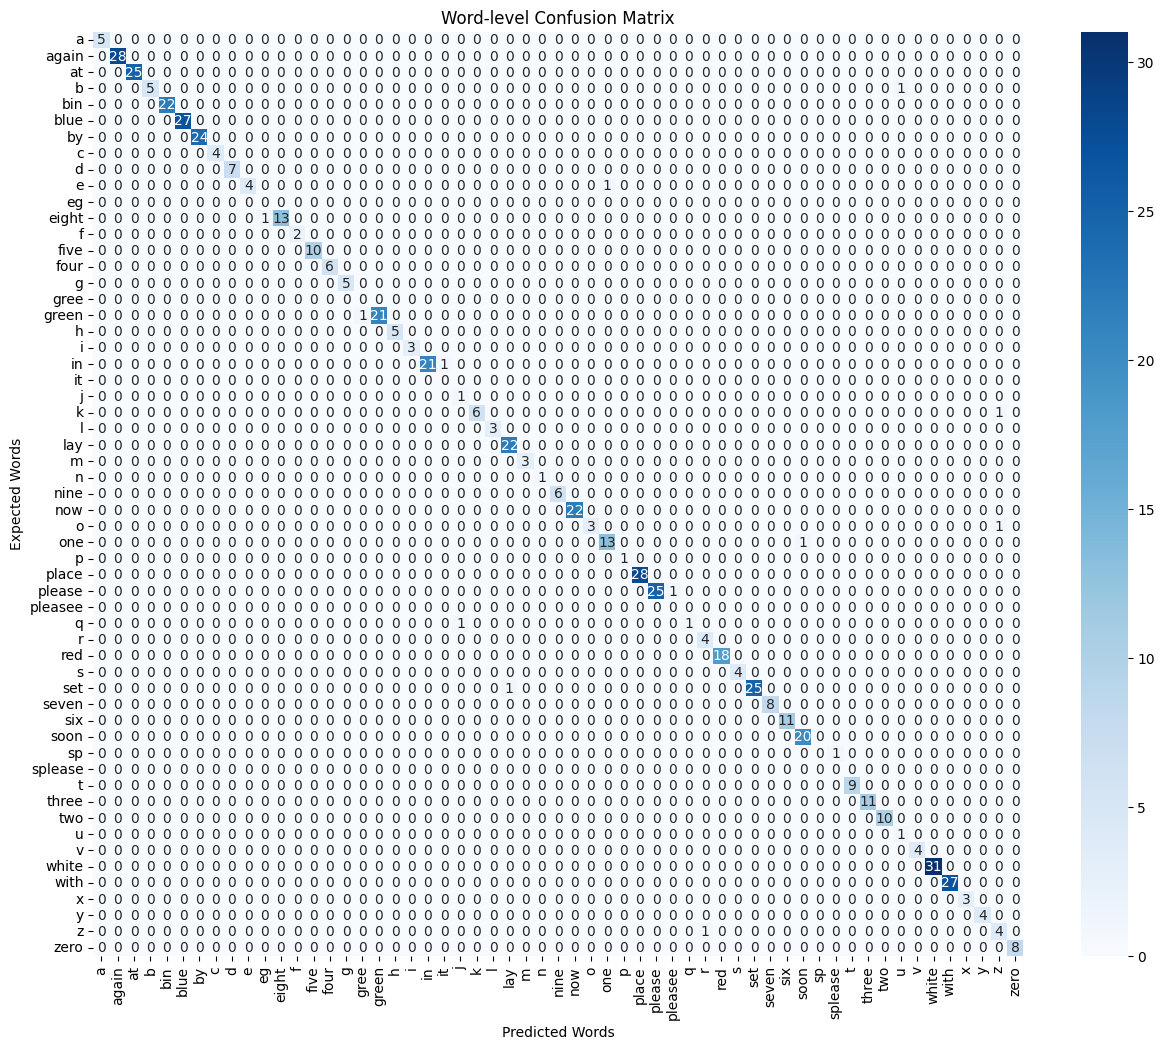

In [94]:
generate_word_confusion_matrix(predicted_label_arr, ground_truth_arr)

## Word Error Rate (WER)

Word Error Rate (WER) is an evaluation metric commonly used to measure the accuracy of predicted text compared to ground truth labels. It calculates the minimum number of substitutions, deletions, and insertions required to align the predicted and true text, normalized by the total number of words.

The formula for calculating WER is as follows:

WER = (S + D + I) / N

where:
- S is the number of word substitutions,
- D is the number of word deletions,
- I is the number of word insertions,
- N is the total number of words in the ground truth labels.

In [96]:
def calculate_wer(predicted, ground_truth):
    """
    Calculate Word Error Rate (WER)
    """ 
    total_words = 0
    total_errors = 0

    for pred_sent, true_sent in zip(predicted, ground_truth):
        pred_words = pred_sent.split()
        true_words = true_sent.split()

        # Calculate the Levenshtein distance
        distance = nltk.edit_distance(pred_words, true_words)

        total_words += len(true_words)
        total_errors += distance

    wer = float(total_errors) / total_words

    return wer

In [97]:
wer = calculate_wer(predicted_label_arr, ground_truth_arr)

In [100]:
print(f"Word Error Rate: {wer*100:.2f}%")
# WER is always bigger than CER or same as edge case


# if sir asks why didnt you something BLeu or Metroer or some common nlp metrics, say that ths is not s pure nlp problem/
# Rather it is a hybrid classification task which overalps with NLP

Word Error Rate: 2.21%
